Problema do MIST

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from time import time

In [ ]:
#!pip install torch torchvision


In [ ]:
# verificar se tem armazenamento gpu para teste, não tem, vai ser um teste lento na cpu
# podemos migrar do vscode para o google colab se ficar muito lento - huina
# import torch
# print(torch.__version__)
# print(torch.cuda.is_available())  # Retorna True se houver GPU compatível


In [3]:
# base de dados do site do Yann lecun - https://yann.lecun.org/exdb/mnist/index.html
# Transformação: converte a imagem em tensor
transform = transforms.ToTensor()

# Dataset de treinamento
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Dataset de validação/teste
valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
valloader = DataLoader(valset, batch_size=64, shuffle=True)

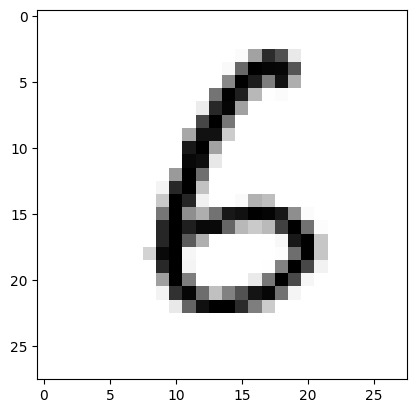

In [4]:
dataiter = iter(trainloader) # carrega os dados do MNIST em lotes de 64 imagens.
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [5]:
print(imagens[0].shape)
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


In [6]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 128)     # Entrada: 784 pixels → 128 neurônios
        self.linear2 = nn.Linear(128, 64)          # 128 → 64
        self.linear3 = nn.Linear(64, 10)           # 64 → 10 classes (dígitos)

# É uma rede neural simples, com 3 camadas lineares (“fully connected”):
# Entrada: a imagem achatada de 784 pixels (28x28).
# Camada escondida 1: 128 neurônios com ReLU.
# Camada escondida 2: 64 neurônios com ReLU.
# Saída: 10 neurônios (um para cada dígito 0-9) com softmax log (probabilidades).

    def forward(self, X):
        X = X.view(X.shape[0], -1)                 # Achata a imagem de (1, 28, 28) para (784)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1) 

In [ ]:
# Funcao do treino
# Para cada batch de imagens:
# Passa as imagens pelo modelo (forward).
# Compara saída com as etiquetas (perda).
# Calcula gradientes (backward).
# Atualiza os pesos (otimizador.step).
# Ao fim de cada época, printa perda média e acurácia para acompanhar o progresso.

def treino(modelo, trainloader, valloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
    criterio = nn.NLLLoss()
    EPOCHS = 10

    perdas = []
    acuracias = []

    modelo.to(device)

    for epoch in range(EPOCHS):
        modelo.train()
        perda_acumulada = 0

        for imagens, etiquetas in trainloader:
            imagens, etiquetas = imagens.to(device), etiquetas.to(device)
            imagens = imagens.view(imagens.size(0), -1)

            otimizador.zero_grad()
            output = modelo(imagens)
            perda_instantanea = criterio(output, etiquetas)
            perda_instantanea.backward()
            otimizador.step()

            perda_acumulada += perda_instantanea.item()

        perda_media = perda_acumulada / len(trainloader)
        perdas.append(perda_media)

        # Avaliar acurácia após essa época
        acuracia = validacao(modelo, valloader, device, print_result=False)
        acuracias.append(acuracia)

        print(f"EPOCH {epoch + 1} - Perda média: {perda_media:.4f} - Acurácia: {acuracia:.2f}%")

    print("\nTreinamento finalizado.")
    return perdas, acuracias


In [8]:
# Avalia o desempenho do modelo com dados que ele não viu durante o treino, para saber se ele está
# generalizando ou só decorando os exemplos.

def validacao(modelo, valloader, device, print_result=True):
    conta_corretas, conta_todas = 0, 0
    modelo.eval()

    with torch.no_grad():
        for imagens, etiquetas in valloader:
            imagens, etiquetas = imagens.to(device), etiquetas.to(device)
            for i in range(len(etiquetas)):
                img = imagens[i].view(1, -1)
                logps = modelo(img)
                ps = torch.exp(logps)
                probab = ps.cpu().numpy()[0]
                etiqueta_pred = probab.argmax()
                etiqueta_certa = etiquetas[i].item()
                if etiqueta_certa == etiqueta_pred:
                    conta_corretas += 1
                conta_todas += 1

    acuracia = conta_corretas * 100 / conta_todas

    if print_result:
        print(f"Total de imagens testadas = {conta_todas}")
        print(f"Precisão do modelo = {acuracia:.2f}%")
    
    return acuracia

In [9]:
def plot_historico(perdas, acuracias):
    epochs = range(1, len(perdas) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, perdas, 'r-', label='Perda')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Perda durante o Treino')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acuracias, 'b-', label='Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia (%)')
    plt.title('Acurácia durante o Treino')
    plt.legend()

    plt.tight_layout()
    plt.show()



EPOCH 1 - Perda média: 1.1520 - Acurácia: 87.56%
EPOCH 2 - Perda média: 0.3833 - Acurácia: 90.77%
EPOCH 3 - Perda média: 0.3114 - Acurácia: 92.06%
EPOCH 4 - Perda média: 0.2727 - Acurácia: 93.01%
EPOCH 5 - Perda média: 0.2430 - Acurácia: 93.72%
EPOCH 6 - Perda média: 0.2181 - Acurácia: 94.12%
EPOCH 7 - Perda média: 0.1970 - Acurácia: 94.48%
EPOCH 8 - Perda média: 0.1792 - Acurácia: 94.61%
EPOCH 9 - Perda média: 0.1636 - Acurácia: 95.30%
EPOCH 10 - Perda média: 0.1504 - Acurácia: 95.48%

Treinamento finalizado.


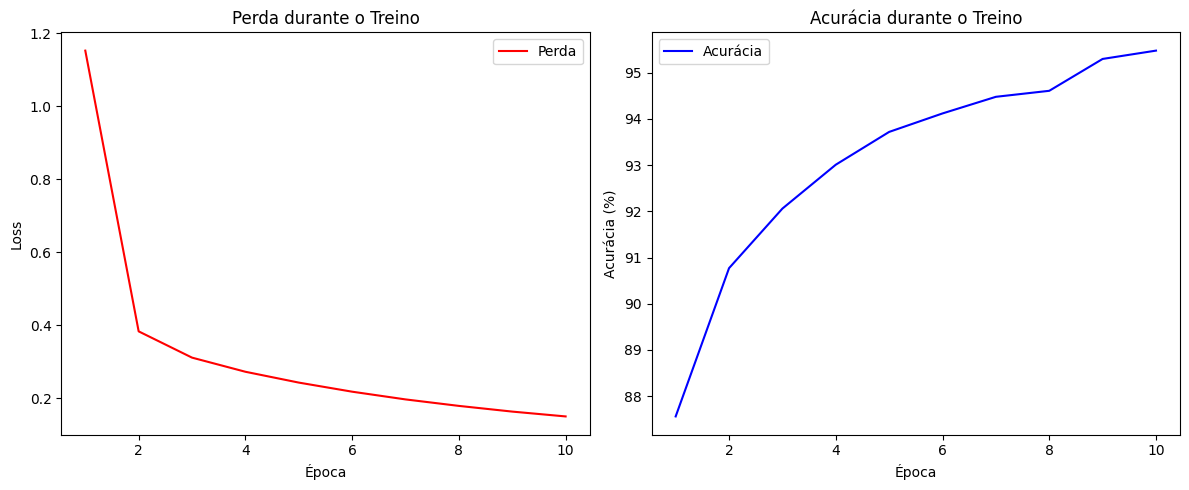

In [10]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

perdas, acuracias = treino(modelo, trainloader, valloader, device)
plot_historico(perdas, acuracias)